In [1]:
# think about combination ratios, and how to make it even. 
# also do recalibration for the keypress detector, in case it's getting a bit to jumpy.
# test old and recalibrated model on online data. this should all be 100%, or close to it. 
# test both on old data 
# show the average loss contribution of each finger. 
# would be good to investigate how far online data is from optimal alignment

# LATER ALLIGATOR
# make ANT internal 

In [2]:
offline_dir = "derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task"
online_dir = "derek_d3_online_recal_2024-09-26-1545_Closed-Loop-Typing-Task"

name = offline_dir + "_multiclass_recal_debug"
offline_model_dir = offline_dir + "_multiclass"

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.data.key_dataset import remove_overlaps, select_keys, create_windows, KeyDataset
from src.data.filter import Filter
from src.data.utils import bipolar_conversion, load_data, key_counts, load_data_deprecated
from src.visualization.visualize import layout
from src.utils import load_config
from src.models.keydecoder import KeyDecoder
from src.models.train import train
from src.models.utils import Experiment
import importlib
import operator
from functools import reduce

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(


## Backspace label removal


In [4]:
data_dir = "/home/john/rumi/data/"

def get_data(expt_list, layout, omit_backspace = None, backspace_key = ord('g'), open_key = ord('f'), filter_params=None):
    datasets = []
    if omit_backspace is None: 
        omit_backspace = [False]*len(expt_list)
    for expt_idx, expt_name in enumerate(expt_list):
        key_fname = data_dir + expt_name + "/data_streams/key_stream.bin"
        emg_fname = data_dir + expt_name + "/data_streams/emg_stream.bin"
        key_data = load_data(key_fname)
        emg_data = load_data(emg_fname)
        emg_names = ['emgbuffer'] + list(emg_data.dtype.names)[1:]
        key_names = ['keybuffer'] + list(key_data.dtype.names)[1:]
        emg_data.dtype.names = emg_names
        key_data.dtype.names = key_names
        print([chr(i) for i in key_data['keybuffer'][:80, 1]])
        
#         print(emg_data.shape)
#         for i in range(0, 100):
#            print(emg_data[i][-1])
        new_key_data = np.zeros(key_data.size, 
                                dtype=[('keybuffer', '<i8', (3,)), ('emg_stream_step', '<i8'), ('key_stream_step', '<i8'), ('time_ns', '<i8')])
        new_key_data['keybuffer'] = np.concatenate((np.zeros_like(key_data['keybuffer'][:, 1:2]), 
                                                key_data['keybuffer']), axis=1)
        new_key_data['emg_stream_step'] = key_data['emg_stream_step']
        new_key_data['key_stream_step'] = key_data['key_stream_step']
        new_key_data['time_ns'] = key_data['time_ns']

        # remove backspace and deleted letters from online recalibration dataset
        if omit_backspace[expt_idx]:    
            for idx in range(new_key_data.shape[0]): 
                # fix online/offline labeling discrepancy post-hoc, only done for online/backspace-omitted datasets
                if new_key_data[idx][0][2] >= 99:
                    new_key_data[idx][0][2] = new_key_data[idx][0][2]+1
                    
            typed_keys = []
            for idx in range(new_key_data.shape[0]): 
                if new_key_data[idx][0][2] == backspace_key:
                    if len(typed_keys): # handle edge case of empty list
                        typed_keys.pop()
                elif new_key_data[idx][0][2] == open_key:
                # remove online recal for "open" gesture, or more generally, the scrolling gesture for rwkv
                    continue
                else:
                    typed_keys.append(idx)
            new_key_data = new_key_data[typed_keys]

            

        emg_stream = emg_data['emgbuffer']
        
        dataset = KeyDataset(emg_stream, new_key_data, layout, window_pre, window_post, subwindow_len,
                             start_channel=1, 
                             end_channel=65, bipolar=False, avg_ref=True, binary=False, 
                             include_blanks=False, 
                             limit_blanks=False,
                             filter_params=filter_params)

        datasets.append(dataset)
    full = reduce(operator.add, datasets)
    full.print_counts()
    data = full.to_numpy(include_full_windows=True)
    return data

In [5]:
rhythm_layout = ['a', 's', 'd', 'f']
binary_layout = [0, 1]
right_layout = ['j', 'k', 'l', ';']
six_finger_layout = ['a', 's', 'd', 'f', 'g', 'h']
new_layout = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
two_fingers_layout = ['g', 'h']
four_finger_layout = ['a', 'c', 'd', 'e']

window_pre = 800 #//2
window_post = 800 #//2
subwindow_len = 480 #//2

In [6]:
fs = 4000.0
filter_params = None
print('filter_params: ',  filter_params)
print('layout: ', new_layout)

expt_names = [offline_dir]
offline_data = get_data(expt_names, new_layout, filter_params=filter_params)

expt_names = [online_dir]
online_data = get_data(expt_names, new_layout, omit_backspace = [True], filter_params=filter_params)

# expt_names = [offline_dir, online_dir]
# combined_data = get_data(expt_names, new_layout, omit_backspace= [False, True], filter_params=filter_params)

print(online_data.dtype)
print(online_data['key_label'].shape)

filter_params:  None
layout:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
['a', 'a', 'e', 'h', 'd', 'a', 'g', 'h', 'b', 'f', 'e', 'b', 'g', 'b', 'g', 'g', 'b', 'b', 'g', 'f', 'e', 'f', 'g', 'h', 'a', 'g', 'a', 'a', 'a', 'h', 'b', 'f', 'a', 'b', 'a', 'h', 'd', 'g', 'f', 'h', 'h', 'g', 'b', 'd', 'f', 'h', 'd', 'b', 'e', 'h', 'h', 'f', 'h', 'g', 'b', 'b', 'e', 'a', 'd', 'd', 'd', 'e', 'f', 'f', 'g', 'g', 'f', 'd', 'h', 'b', 'b', 'g', 'f', 'a', 'g', 'b', 'g', 'f', 'd', 'f']
97, a: 99
98, b: 100
100, d: 100
101, e: 100
102, f: 100
103, g: 100
104, h: 100
['a', 'a', 'f', 'c', 'c', 'a', 'b', 'b', 'd', 'd', 'a', 'f', 'e', 'g', 'b', 'd', 'g', 'a', 'a', 'b', 'd', 'g', 'c', 'd', 'a', 'a', 'b', 'b', 'b', 'g', 'b', 'c', 'c', 'c', 'b', 'd', 'c', 'c', 'c', 'g', 'd', 'd', 'd', 'd', 'c', 'c', 'a', 'g', 'a', 'd', 'd', 'f', 'f', 'd', 'a', 'd', 'd', 'b', 'g', 'a', 'b', 'd', 'f', 'f', 'b', 'a', 'c', 'b', 'b', 'b', 'd', 'g', 'c', 'c', 'f', 'f', 'd', 'c', 'c', 'g']
97, a: 82
98, b: 60
100, d: 90
101, e: 79
104,

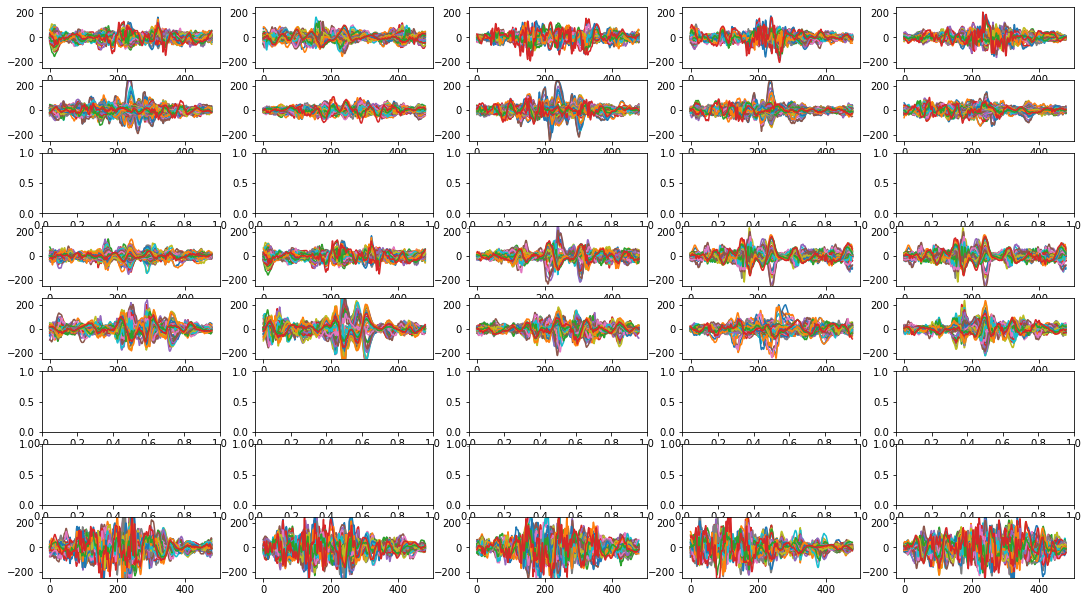

In [7]:
##VIS CODE
y = online_data['emg_windows']
x = np.arange(0, subwindow_len)

# plot early data: 
# grab dimensions from data object
fig, axes = plt.subplots(8,5)
fig.set_size_inches(18.5, 10.5, forward=True)
subplot_tracker = 8*[0]
for i in range(0, 50):
#     if(chr(int(data['key_label'][i])) not in ['h']):
#         continue

#     print(np.mean(np.abs((y[i, 240, :]))))
    row_plot = int(online_data['key_label'][i]) - ord("a")
    if subplot_tracker[row_plot] > 4: 
        continue
#     axes[row_plot][subplot_tracker[row_plot]].set_title(chr(int(data['key_label'][i])))
    for j in range(0, 64):
#         if(j == 31 or j == 30 or j == 32 or j == 29):
#             continue
        axes[row_plot][subplot_tracker[row_plot]].plot(x, y[i, :, j])
    
    axes[row_plot][subplot_tracker[row_plot]].set_ylim(-250,250)
    subplot_tracker[row_plot] = subplot_tracker[row_plot] + 1
    
plt.show()

## Testing on Online Data
1. load online data, see how the label distribution looks, how the signals look before and after pruning the deleted characters.

In [8]:
config = load_config("/home/john/emg_decoder/configs/keydecoder.yaml")
#config['model']['data_scale'] = 1.0e6

In [10]:
# take combined-data
# shuffle: bc want high performance on both offline and online data, so validation on online and offline both matter? 
# alternative: train on both, val on online? this may be best for online performance...? 

# this replaces half of the offline train data with online, and tests/validates on online data.
# assumes 60 samples per finger
train_data_online, val_test_data = train_test_split(online_data,
#                                             train_size=config['data']['train_proportion'],
                                             train_size=0.66,
                                            stratify=online_data['key_label'],
                                            random_state=config['random_seed'])
train_data_offline, _ =  train_test_split(offline_data,
#                                             train_size=config['data']['train_proportion'],
                                             train_size=0.4,
                                            stratify=offline_data['key_label'],
                                            random_state=config['random_seed'])
train_data_offline_pup_open, _ =  train_test_split(offline_data,
#                                             train_size=config['data']['train_proportion'],
                                             train_size=0.8,
                                            stratify=offline_data['key_label'],
                                            random_state=config['random_seed'])
# take all the pinky up and open gestures from the offline data
indices = []
for i in range(train_data_offline_pup_open.shape[0]-1,-1,-1):  
    if  train_data_offline_pup_open['key_label'][i] == ord('f') or  train_data_offline_pup_open['key_label'][i] == ord('g'):

        not_in_first_fold = True
        for j in range(train_data_offline.shape[0]):
            if train_data_offline[j] == train_data_offline_pup_open[i]:
                not_in_first_fold = False 
                break 
        if not_in_first_fold: 
            indices.append(i)
train_data_offline_pup_open = train_data_offline_pup_open[indices]

train_data = np.concatenate((train_data_offline, train_data_offline_pup_open, train_data_online))
print(train_data.shape)
# relative_val_proportion = config['data']['val_proportion'] / (1 - config['data']['train_proportion'])

val_data, test_data = train_test_split(val_test_data,
                                      train_size=0.5,
                                       stratify=val_test_data['key_label'],
                                       random_state=config['random_seed'])

train_dataset = KeyDataset(None, None, None, None, None, subwindow_len, init=False, binary=True)
train_dataset.full_windows = train_data['full_windows']
train_dataset.X = train_data['emg_windows']
train_dataset.y = train_data['key_label']
train_dataset.start_idxs = train_data['start_idxs']
train_dataset.num_chans = train_dataset.X.shape[-1]

train_dataset.print_counts()
for class_id in np.unique(train_dataset.y):
    train_dataset.augment_class(class_id,  num_views = 10, var_factor=4, time_shift=True, add_noise=False, in_place=True)
train_dataset.print_counts()
train_data = train_dataset.to_numpy(include_full_windows=False)

(605,)
97, a: 93
98, b: 80
100, d: 99
101, e: 92
102, f: 80
103, g: 80
104, h: 81
97.0, a: 930
98.0, b: 800
100.0, d: 990
101.0, e: 920
102.0, f: 800
103.0, g: 800
104.0, h: 810


In [11]:
print(name)
print(train_dataset.to_numpy(include_full_windows=False).size, val_data.size, test_data.size)
processed_data_dir = "/home/john/emg_decoder/data/processed/"
train_path = processed_data_dir + name + "_train.npy"
val_path = processed_data_dir + name + "_val.npy"
test_path = processed_data_dir + name + "_test.npy"
path = processed_data_dir + name
np.save(train_path, train_dataset.to_numpy(include_full_windows=False))
np.save(val_path, val_data)
#
#
np.save(test_path, test_data)

config['data']['window_length'] = subwindow_len
config['model']['loss'] = 'CrossEntropyLoss'
config['data']['train_path'] = train_path
config['data']['val_path'] = val_path
config['data']['test_path'] = test_path
config['name'] = name
config['root_dir'] = "/home/john/emg_decoder"

derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug
6050 63 64


In [12]:
system_type = KeyDecoder
experiment_dir = f"/home/john/emg_decoder/models/{config['name']}"
offline_experiment_dir = f"/home/john/emg_decoder/models/"+offline_model_dir
accelerator = 'cuda'
devices = [0]

# model.load_state_dict(torch.load(PATH), weights_only=True)
# torch.save()


system, trainer = train(
        system_type,
        config,
        experiment_dir=experiment_dir,
        accelerator=accelerator,
        devices=devices,
        run=False
        )
# should i load it as a ckpt or as a pytorch model like I'm doing now? 
# system = KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + "bell-epoch=09-val_loss=0.05.ckpt")

system.load_state_dict(torch.load(f"{offline_experiment_dir}/models/"+offline_model_dir+".pt"))
trainer.fit(system, ckpt_path=None)


Seed set to 4995


/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


data_scale tensor(1.)


You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/john/emg_decoder/models/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug/lightning_logs


/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


2024-09-26 15:56:10.013486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 15:56:10.106288: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params
---------------------------------------------
0 | loss  | CrossEntropyLoss   | 0     
1 | acc   | MulticlassAccuracy | 0     
2 | model | KeyClassifier      | 147 K 
---------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     T

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

In [20]:
expt = Experiment(system_type, experiment_dir, version=0)
LIST_of_checkpoints = expt.list_checkpoints()[1:]
print(LIST_of_checkpoints)

Versions: ['0'] available, loading version 0...
['bell-epoch=10-val_loss=1.34.ckpt', 'last.ckpt', 'bell-epoch=00-val_loss=1.03.ckpt', 'bell-epoch=11-val_loss=1.33.ckpt', 'bell-epoch=01-val_loss=1.06.ckpt', 'bell-epoch=06-val_loss=1.40.ckpt']


bell-epoch=10-val_loss=1.34.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                 0.765625
        test_loss           1.5937821865081787
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

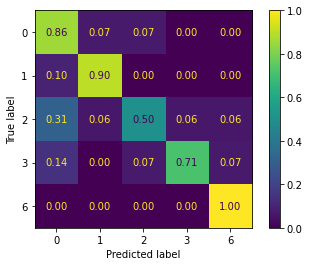

last.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                 0.828125
        test_loss            1.557279348373413
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

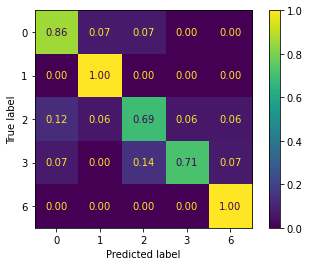

bell-epoch=00-val_loss=1.03.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                  0.71875
        test_loss           0.8932233452796936
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

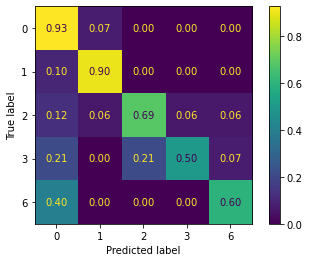

bell-epoch=11-val_loss=1.33.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                  0.8125
        test_loss           1.1493505239486694
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

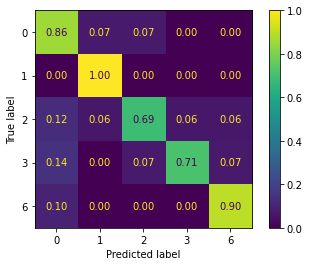

bell-epoch=01-val_loss=1.06.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                  0.78125
        test_loss           0.9372406601905823
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

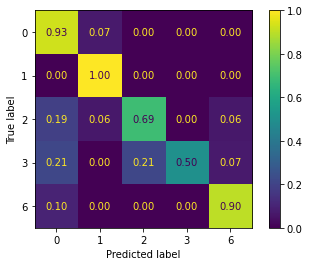

bell-epoch=06-val_loss=1.40.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                 0.828125
        test_loss           1.2268543243408203
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

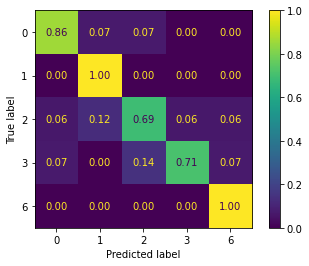

/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                 0.828125
        test_loss            1.557279348373413
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

best ckpt:  [{'test_loss': 1.557279348373413, 'test_acc': 0.828125}]


In [21]:
# system=KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + "last.ckpt")
# trainer.test(system)
# out = trainer.predict(system)

best_ckpt = ''
best_acc = 0
for ckpt in LIST_of_checkpoints: 
    print(ckpt)
    system=KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + ckpt, strict=False)
    ret = trainer.test(system)
    if ret[0]['test_acc'] > best_acc:
        best_ckpt = ckpt
        best_acc = ret[0]['test_acc']
    out = trainer.predict(system)
    ys = np.concatenate([a[1] for a in out])
    preds = np.hstack([torch.argmax(a[0], axis=1) for a in out])
    disp = ConfusionMatrixDisplay.from_predictions(ys, preds, normalize='true', values_format='.2f')
    plt.show()
system=KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + best_ckpt, strict=False)
test_perf = trainer.test(system)
out = trainer.predict(system)
print('best ckpt: ', test_perf)

In [15]:
# # if i want to override the choice
# best_ckpt = "bell-epoch=05-val_loss=0.28.ckpt"
# system=KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + best_ckpt, strict=False)
# test_perf = trainer.test(system)
# out = trainer.predict(system)
# disp = ConfusionMatrixDisplay.from_predictions(ys, preds, normalize='true', values_format='.2f')

In [22]:
Xs = np.concatenate([a[0] for a in out])
ys = np.concatenate([a[1] for a in out])
print(Xs.shape, ys.shape)
preds = np.hstack([torch.argmax(a[0], axis=1) for a in out])

(64, 7) (64,)


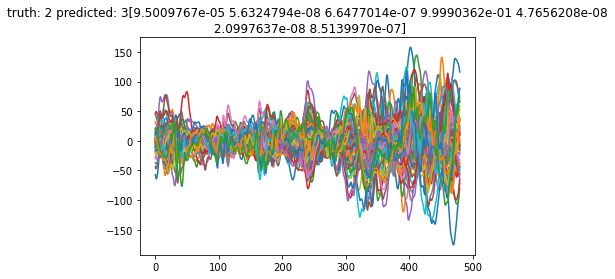

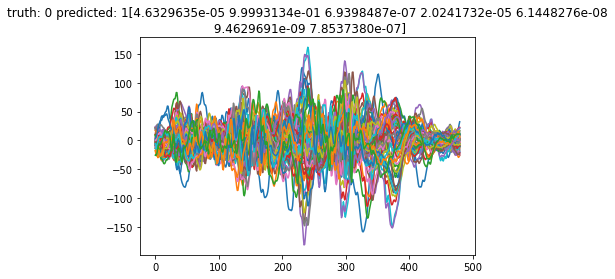

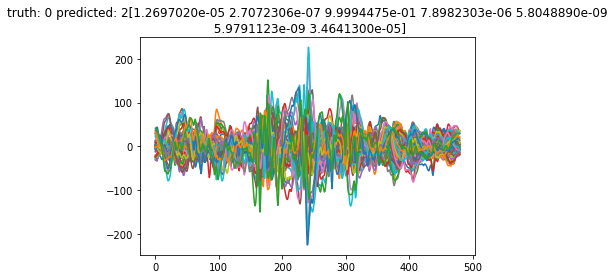

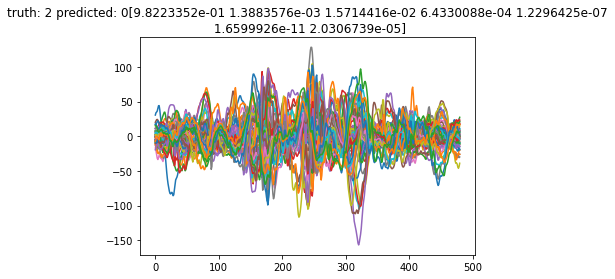

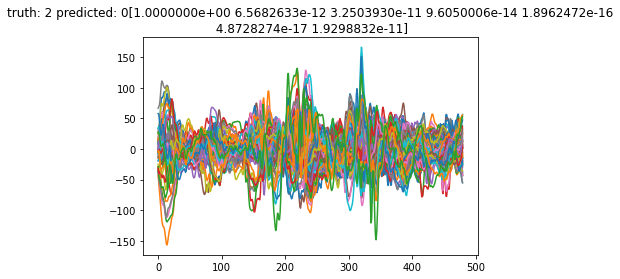

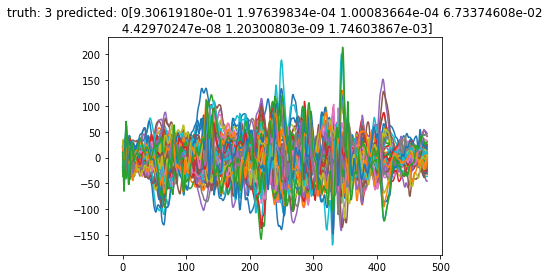

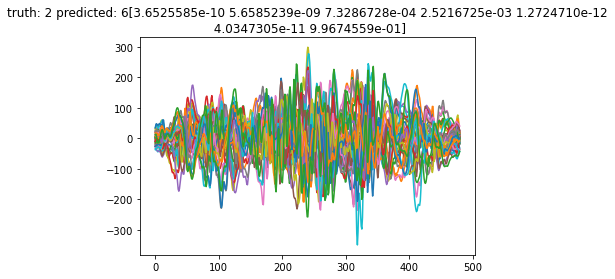

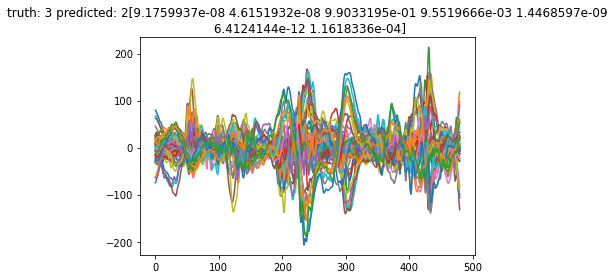

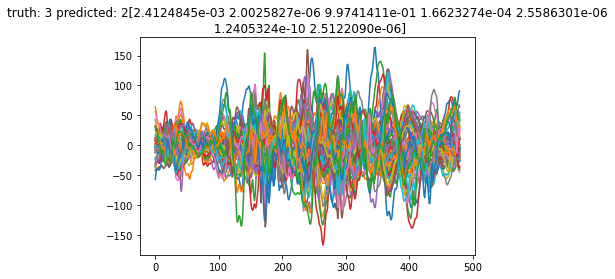

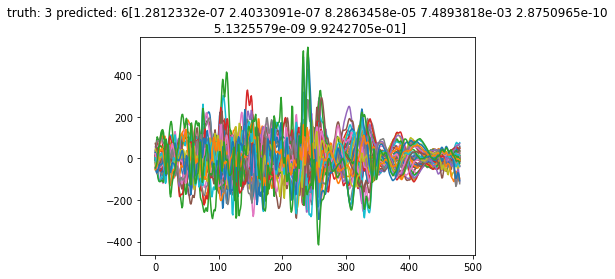

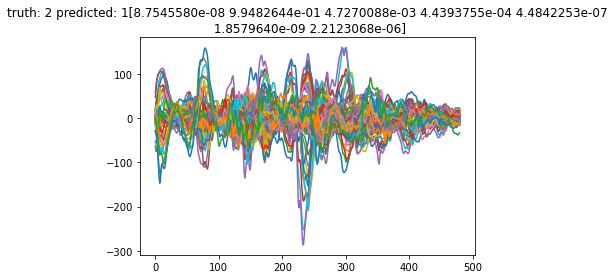

In [23]:
##Plot errors
from scipy.special import softmax
x = np.arange(0, subwindow_len)
y = test_data['emg_windows']
for i in range(len(ys)):
    if(ys[i] != preds[i]):
        plt.figure(i)

        temp = "truth: " + str(ys[i]) + " predicted: " + str(preds[i]) + str(softmax(Xs[i]))
        plt.title(temp)

        for j in range(1, 64):
            plt.plot(x, y[i, :, j])
        plt.show()

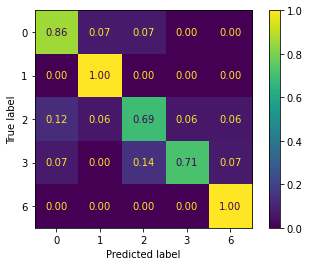

In [24]:
disp = ConfusionMatrixDisplay.from_predictions(ys, preds, normalize='true', values_format='.2f')


In [25]:
torch.save(system.state_dict(), f"{experiment_dir}/models/{config['name']}.pt")
print(f"experiment_directory: {experiment_dir}")
print(f"checkpoint_name: {config['name']}.pt")

experiment_directory: /home/john/emg_decoder/models/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug
checkpoint_name: derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_multiclass_recal_debug.pt
